# **AIE425 Intelligent Recommender Systems**  
### **Fall Semester 24/25**  

---

## **Personalized Educational Game Recommendation System**  

---

### **221100583, Mohammed Haitham Mohammed**  
### **221100500, Maryam Eslam Sameer**


## Imports and Setup

In [10]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

## Load and Preprocess Dataset

In [11]:
file_path = r"C:\Users\medoh\OneDrive\Desktop\AIE425 Intelligent recommender systems\Project\FINALDATA.csv"
data = pd.read_csv(file_path)

data = data.drop(
    columns=["is_free","supported_languages","header_image","website","categories"],
    errors="ignore"
)

data = data.fillna("")

# Clean short_description
data["short_description"] = data["short_description"].str.lower()
data["short_description"] = data["short_description"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x).strip()
)

# Ensure these exist
genre_cols = ["genre1","genre2","genre3","genre4","genre5","genres6","genres7"]
for gc in genre_cols:
    if gc not in data.columns:
        data[gc] = ""

# Clean name
data["clean_name"] = data["name"].str.lower()
data["clean_name"] = data["clean_name"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x).strip()
)

## Cluster Game Names Automatically

In [12]:
unique_names = data["clean_name"].unique()

tfidf_vec = TfidfVectorizer(stop_words="english").fit(unique_names)
name_tfidf = tfidf_vec.transform(unique_names)

dbscan_model = DBSCAN(
    eps=0.3,
    min_samples=1,
    metric="cosine"
)
cluster_labels = dbscan_model.fit_predict(name_tfidf)

cluster_map = {}
for label, n in zip(cluster_labels, unique_names):
    cluster_map.setdefault(label, []).append(n)

cluster_rep = {}
for lbl, name_list in cluster_map.items():
    rep = min(name_list, key=len)
    cluster_rep[lbl] = rep

name_to_rep = {}
for lbl, name_list in cluster_map.items():
    rep = cluster_rep[lbl]
    for nm in name_list:
        name_to_rep[nm] = rep

data["unified_name"] = data["clean_name"].apply(lambda x: name_to_rep[x])

## Build Grouped Rows

In [13]:
grouped_rows = []
grouped_unames = data["unified_name"].unique()

for uname in grouped_unames:
    subset = data[data["unified_name"]==uname]
    merged_desc = " ".join(subset["short_description"].tolist())
    avg_rating = subset["ratings"].astype(float).mean()
    max_age = subset["required_age"].astype(float).max()
    all_genres = []
    for _, row in subset.iterrows():
        local_gs = []
        for gc in genre_cols:
            if row[gc] != "":
                local_gs.append(row[gc])
        all_genres += local_gs
    all_genres = list(set(all_genres))
    grouped_rows.append({
        "unified_name": uname,
        "required_age": max_age,
        "ratings": avg_rating,
        "merged_description": merged_desc,
        "merged_genres": all_genres
    })

df_grouped = pd.DataFrame(grouped_rows)

## Create One-Hot Genre Vectors

In [14]:
all_g_set = set()
for g_list in df_grouped["merged_genres"]:
    for g in g_list:
        all_g_set.add(g)
all_genres_sorted = sorted(list(all_g_set))

def create_genre_vector(row_gs, full_gs):
    vec = [0]*len(full_gs)
    for g in row_gs:
        if g in full_gs:
            idx = full_gs.index(g)
            vec[idx] = 1
    return vec

genre_vectors = []
for gs in df_grouped["merged_genres"]:
    genre_vectors.append(create_genre_vector(gs, all_genres_sorted))
genre_vectors = np.array(genre_vectors, dtype=float)

## TF-IDF on Merged Descriptions

In [15]:
desc_corpus = df_grouped["merged_description"].values

raw_vocab = set()
for doc in desc_corpus:
    words = doc.split()
    for w in words:
        raw_vocab.add(w)
raw_vocab_list = sorted(list(raw_vocab))

custom_sw = {
    "game","games","play","played","playing","world","players","new",
    "open","will","make","makes","made","thing","things","like"
}

filtered_vocab_list = [v for v in raw_vocab_list if v not in custom_sw]

def term_frequency(doc, vocab):
    counts = [0]*len(vocab)
    words = doc.split()
    for w in words:
        if w in vocab:
            idx = vocab.index(w)
            counts[idx] += 1
    return counts

tf_matrix = []
for doc in desc_corpus:
    tf_matrix.append(term_frequency(doc, filtered_vocab_list))
tf_matrix = np.array(tf_matrix, dtype=float)

doc_freq = np.count_nonzero(tf_matrix, axis=0)
N_docs = len(desc_corpus)

final_vocab = []
valid_idx = []
for i, w in enumerate(filtered_vocab_list):
    ratio = doc_freq[i]/N_docs
    if ratio <= 0.6:
        final_vocab.append(w)
        valid_idx.append(i)

tf_matrix_filtered = tf_matrix[:, valid_idx]
df_filtered = doc_freq[valid_idx]

idf_vals = []
for df_val in df_filtered:
    idf_vals.append(math.log((N_docs+1)/(df_val+1)) + 1)
idf_vals = np.array(idf_vals)

tf_idf_matrix = tf_matrix_filtered * idf_vals

def rowwise_norm(mat):
    out = []
    for row in mat:
        length = np.sqrt(np.sum(row**2))
        if length!=0:
            out.append(row/length)
        else:
            out.append(row)
    return np.array(out)

tf_idf_matrix = rowwise_norm(tf_idf_matrix)

## Combine Features

In [16]:
combined_features = np.hstack([genre_vectors, tf_idf_matrix])

## Manual SVD

In [17]:
def svd_decomposition(matrix, k=None):
    A = np.array(matrix, dtype=float)
    ATA = np.dot(A.T, A)
    AAT = np.dot(A, A.T)
    
    eigvals_ATA, V = np.linalg.eigh(ATA)
    eigvals_AAT, U = np.linalg.eigh(AAT)
    
    idx_v = np.argsort(eigvals_ATA)[::-1]
    idx_u = np.argsort(eigvals_AAT)[::-1]
    
    V = V[:, idx_v]
    U = U[:, idx_u]
    eigvals = eigvals_ATA[idx_v]
    
    if k is not None:
        U = U[:, :k]
        V = V[:, :k]
        eigvals = eigvals[:k]
    
    sigma = np.sqrt(eigvals)
    sigma_matrix = np.diag(sigma)
    return U, sigma_matrix, V.T

K = 30
U, S, Vt = svd_decomposition(combined_features, k=K)
reconstructed = np.dot(np.dot(U, S), Vt)

## Build Item-Item Similarity

In [18]:
def cosine_similarity_matrix(features):
    norms = np.sqrt(np.sum(features**2, axis=1, keepdims=True))
    normed = features/(norms+1e-8)
    sim = np.dot(normed, normed.T)
    return sim

item_sim_matrix = cosine_similarity_matrix(reconstructed)

## Recommendation Function

In [20]:
def recommend_games(
    user_age,    # "below_15" or "above_15"
    user_games,  # list of original names
    user_genres, # list of favored genres
    top_n=5
):
    if user_age=="below_15":
        valid_df = df_grouped[df_grouped["required_age"]<=15].copy()
    else:
        valid_df = df_grouped.copy()
    
    valid_idx = valid_df.index.tolist()
    
    def clean(gm):
        return re.sub(r"[^a-z0-9\s]", "", gm.lower()).strip()
    
    user_cleaned = [clean(gm) for gm in user_games]
    
    rep_indices = []
    for uc in user_cleaned:
        if uc in name_to_rep:
            cluster_rep = name_to_rep[uc]
            row_match = valid_df[valid_df["unified_name"]==cluster_rep]
            if len(row_match)>0:
                ridx = row_match.index[0]
                rep_indices.append(ridx)
        else:
            row_match = valid_df[valid_df["unified_name"]==uc]
            if len(row_match)>0:
                ridx = row_match.index[0]
                rep_indices.append(ridx)
    
    if len(rep_indices)==0:
        valid_df["similarity_score"] = valid_df["ratings"].astype(float)
        valid_df.sort_values("similarity_score", ascending=False, inplace=True)
        return valid_df.head(top_n)
    
    avg_scores = []
    for idx in valid_idx:
        local_sims = []
        for r_idx in rep_indices:
            local_sims.append(item_sim_matrix[idx, r_idx])
        avg_scores.append(np.mean(local_sims))
    valid_df["similarity_score"] = avg_scores
    
    def measure_overlap(row_gs, user_gs):
        row_set = set(row_gs)
        user_set = set(user_gs)
        overlap_count = len(row_set.intersection(user_set))
        if len(user_gs)==0:
            return 0
        return overlap_count/len(user_gs)
    
    overlap_scores = []
    for i, row in valid_df.iterrows():
        overlap_scores.append(measure_overlap(row["merged_genres"], user_genres))
    valid_df["genre_overlap"] = overlap_scores
    
    w_sim = 0.2
    w_genre = 0.5
    w_rat = 0.3
    final_score = []
    for i, row in valid_df.iterrows():
        score = (
            w_sim * row["similarity_score"] +
            w_genre * row["genre_overlap"] +
            w_rat * row["ratings"]
        )
        final_score.append(score)
    valid_df["combined_score"] = final_score
    
    valid_df.sort_values("combined_score", ascending=False, inplace=True)
    top_recs = valid_df.head(top_n).copy()
    
    sim_details = []
    for i, row in top_recs.iterrows():
        txt = ""
        for r_idx in rep_indices:
            rep_name = df_grouped.loc[r_idx,"unified_name"]
            val_sim = item_sim_matrix[i, r_idx]
            txt += f"  Similar to {rep_name} => {val_sim:.3f}\n"
        sim_details.append(txt.strip())
    top_recs["similarity_details"] = sim_details
    
    return top_recs

## Visual Checks

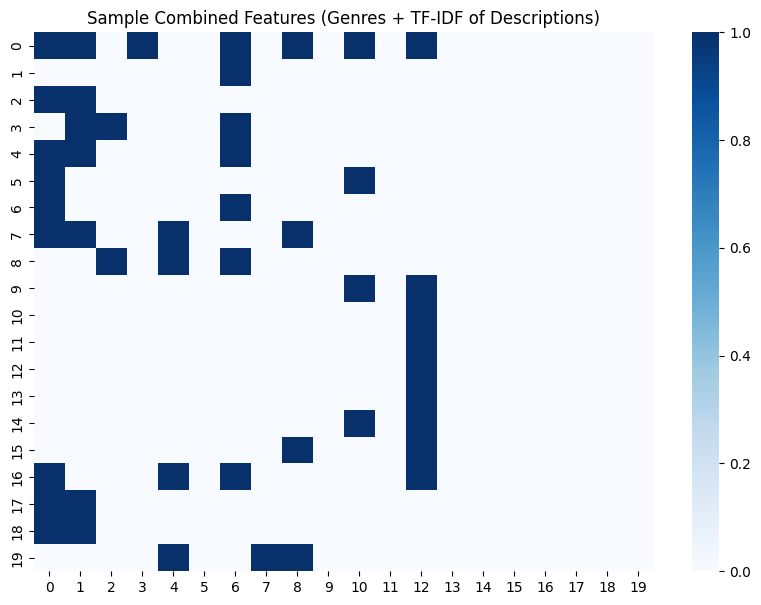

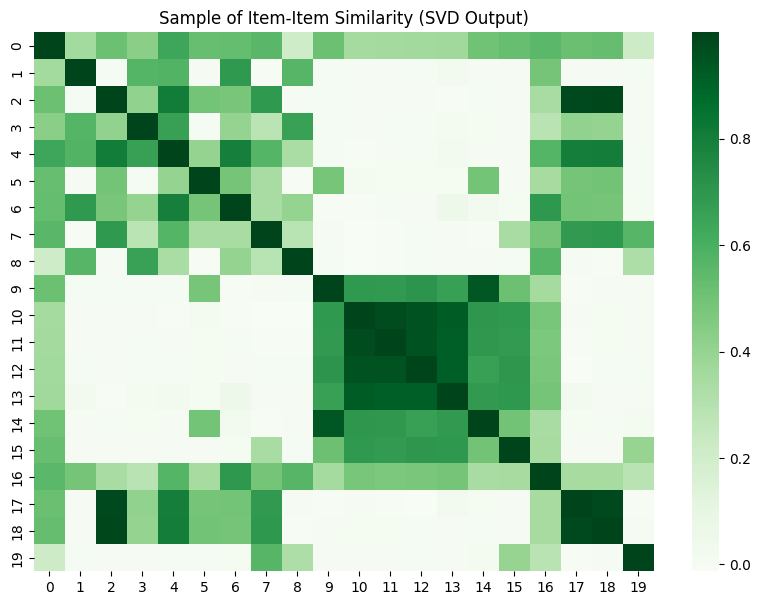

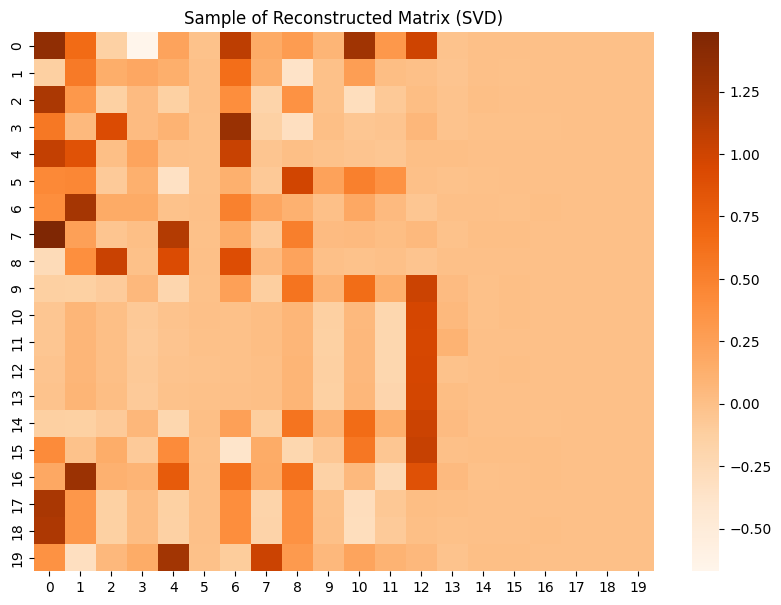

TF-IDF Matrix (non-zero values within first 10×10 slice):

SVD Results:
U Matrix (non-zero values within first 10×10 slice):
Row 0: [(0, 0.0669065366753135), (1, 0.04626636239247913), (2, -0.002450357467714081), (3, 0.03156566043722745), (4, -0.06944080584943249), (5, 0.015338105382081422), (6, -0.012964556851364687), (7, 0.033036554255511746), (8, -0.010743897721817412), (9, -0.03157051368997142)]
Row 1: [(0, 0.013489191325868455), (1, 0.03506009327878076), (2, 0.018742525939113464), (3, -0.006560980715313247), (4, 0.0321383680814213), (5, 0.035875974568526627), (6, 0.0030206659229775577), (7, 0.026817804895170154), (8, 0.014293559194814912), (9, -0.0035173819176262267)]
Row 2: [(0, 0.03314731326786419), (1, -0.03251335198059124), (2, 0.03655670778376023), (3, 0.010840627779255319), (4, -0.01639976295310397), (5, -0.04092174388001278), (6, 0.007846654219288943), (7, 0.00211880214039159), (8, -0.008214562402725136), (9, 0.006795037323623604)]
Row 3: [(0, 0.030562729598098526), (1, 0.04

In [21]:
plt.figure(figsize=(10,7))
sns.heatmap(combined_features[:20,:20], cmap="Blues")
plt.title("Sample Combined Features (Genres + TF-IDF of Descriptions)")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(item_sim_matrix[:20,:20], cmap="Greens")
plt.title("Sample of Item-Item Similarity (SVD Output)")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(reconstructed[:20,:20], cmap="Oranges")
plt.title("Sample of Reconstructed Matrix (SVD)")
plt.show()

import numpy as np

def print_nonzero_slice(matrix, name, max_rows=10, max_cols=10):
    rows = min(max_rows, matrix.shape[0])
    cols = min(max_cols, matrix.shape[1])
    print(f"{name} (non-zero values within first {rows}×{cols} slice):")
    for r in range(rows):
        row_entries = []
        for c in range(cols):
            val = matrix[r, c]
            if abs(val) > 1e-12:
                row_entries.append((c, val))
        if row_entries:
            print(f"Row {r}: {row_entries}")

print_nonzero_slice(tf_idf_matrix, "TF-IDF Matrix")
print()
print("SVD Results:")
print_nonzero_slice(U, "U Matrix")
print_nonzero_slice(S, "Sigma (S) Matrix")
print_nonzero_slice(Vt, "V Transposed (Vt) Matrix")
print()
print_nonzero_slice(reconstructed, "Reconstructed Matrix (after SVD)")
print()
print_nonzero_slice(item_sim_matrix, "Cosine Similarity Matrix")

##  Additional EDA Visualizations

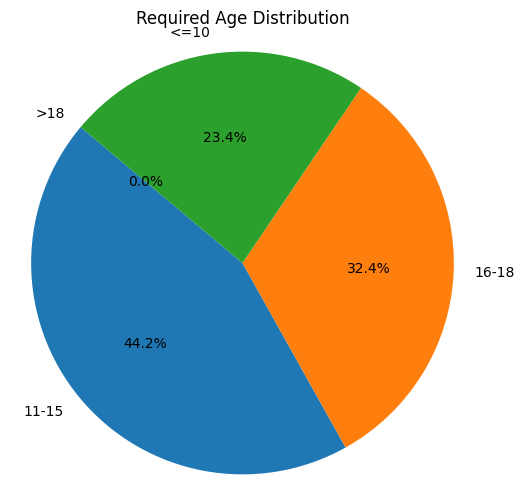

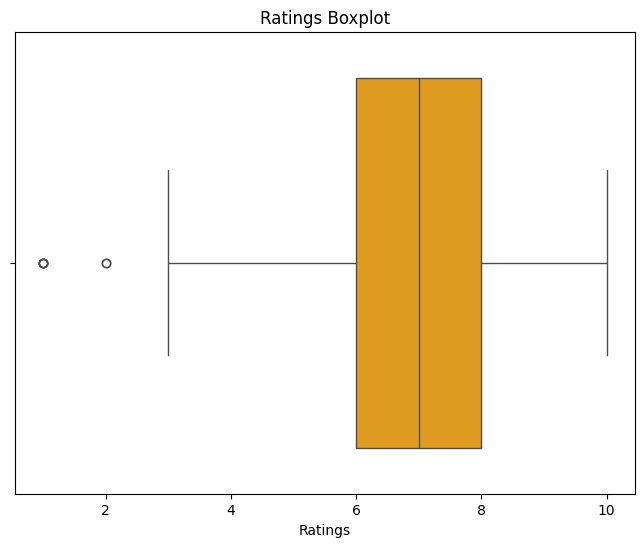

In [22]:
# Cell 13: Additional EDA Visualizations
# 1) Scatter plot: Ratings vs. Required Age
# plt.figure(figsize=(8,6))
# plt.scatter(df_grouped["required_age"], df_grouped["ratings"], c="blue", alpha=0.6)
# plt.xlabel("Required Age")
# plt.ylabel("Rating")
# plt.title("Ratings vs. Required Age Scatter Plot")
# plt.show()

# 2) Correlation heatmap for numeric columns
# numeric_cols = df_grouped.select_dtypes(include=[np.number]).columns.tolist()
# if len(numeric_cols) > 1:
#     corr_matrix = df_grouped[numeric_cols].corr()
#     plt.figure(figsize=(8,6))
#     sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
#     plt.title("Correlation Heatmap of Numeric Columns")
#     plt.show()

# 3) Distribution of cluster sizes
# from collections import Counter
# unified_counts = data["unified_name"].value_counts()

# plt.figure(figsize=(8,6))
# unified_counts.plot(kind="bar", color="purple")
# plt.title("Distribution of Clustered Game Names")
# plt.xlabel("Unified Name")
# plt.ylabel("Count of Original Entries")
# plt.xticks(rotation=45, ha="right")
# plt.show()

# 4) Pie chart of Required Ages (grouped)
age_bins = [0, 10, 15, 18, 100]
age_labels = ["<=10","11-15","16-18",">18"]
df_grouped["age_bin"] = pd.cut(df_grouped["required_age"], bins=age_bins, labels=age_labels, include_lowest=True)
age_dist = df_grouped["age_bin"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(age_dist, labels=age_dist.index, autopct="%1.1f%%", startangle=140)
plt.title("Required Age Distribution")
plt.axis("equal")
plt.show()

# 5) Ratings boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=df_grouped["ratings"], color="orange")
plt.title("Ratings Boxplot")
plt.xlabel("Ratings")
plt.show()

## Additional EDA Without Large Game Names

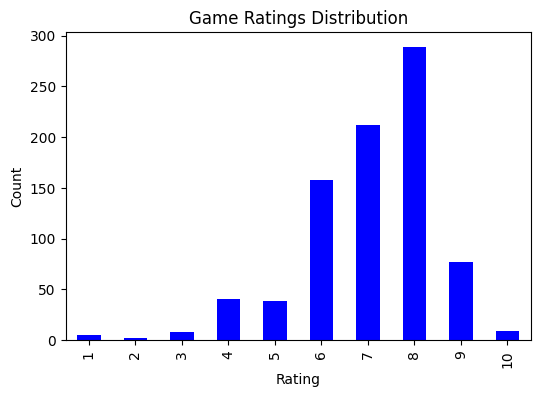

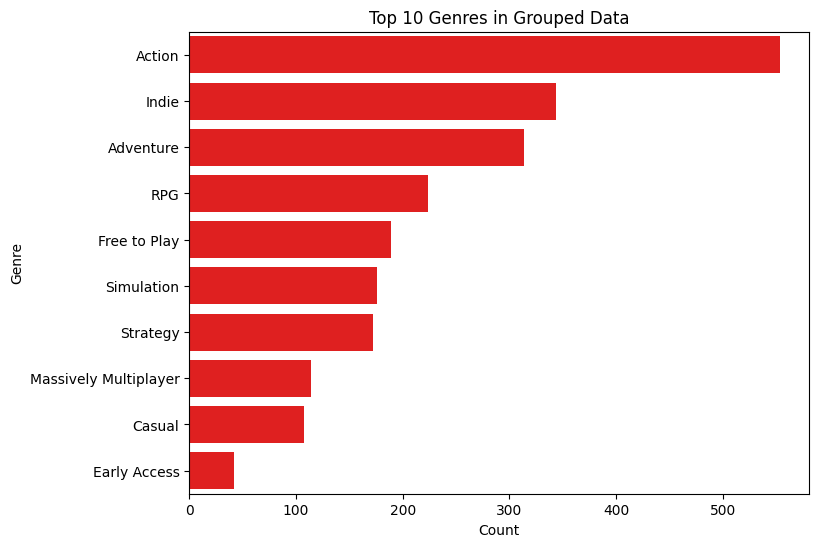

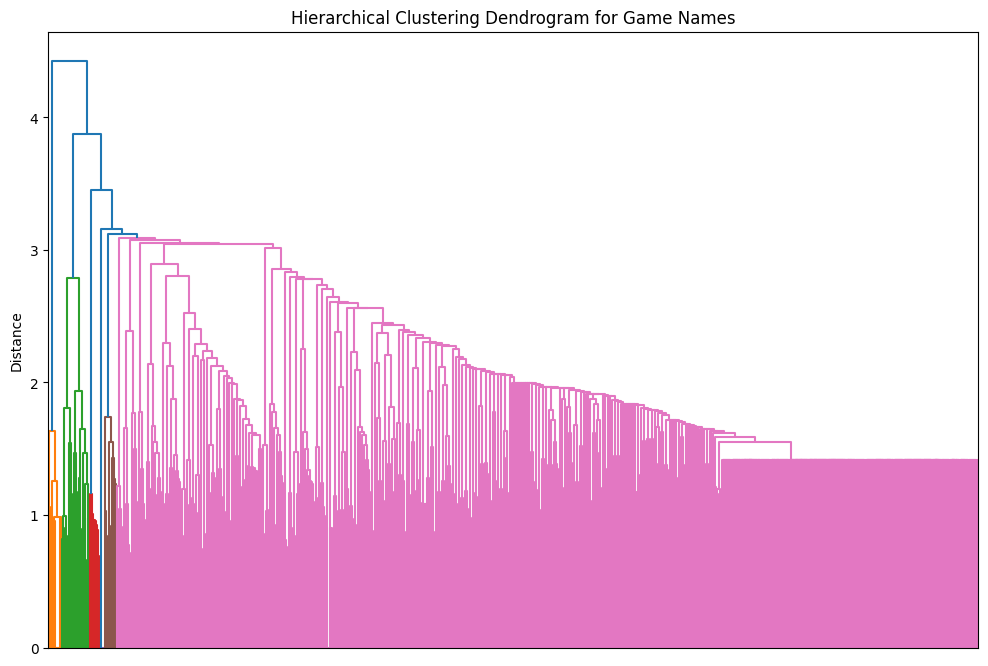

In [23]:
# Cell 14: Additional EDA Without Large Game Names
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Cluster Size Distribution (no names)
# if "cluster_labels" in locals() or "cluster_labels" in globals():
#     cluster_series = pd.Series(cluster_labels)
#     cluster_counts = cluster_series.value_counts()
#     plt.figure(figsize=(8,6))
#     plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="purple")
#     plt.xlabel("Cluster ID")
#     plt.ylabel("Count")
#     plt.title("Cluster Size Distribution")
#     plt.show()

# 2) is_free Distribution
if "is_free" in data.columns:
    plt.figure(figsize=(6,4))
    data["is_free"].value_counts().plot(kind="bar", color="green")
    plt.xticks(rotation=0)
    plt.title("Count of Free vs Paid Games")
    plt.ylabel("Count")
    plt.show()

# 3) Ratings Distribution
df_grouped["ratings"] = df_grouped["ratings"].round().astype(int)
plt.figure(figsize=(6,4))
df_grouped["ratings"].value_counts().sort_index().plot(kind="bar", color="blue")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Game Ratings Distribution")
plt.show()

# 4) Categories Distribution
if "categories" in data.columns:
    cat_series = data["categories"].dropna()
    cat_list = []
    for row in cat_series:
        cat_list.extend([x.strip() for x in row.split(",")])
    cat_counts = pd.Series(cat_list).value_counts().head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=cat_counts.values, y=cat_counts.index, color="orange")
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.title("Top 10 Categories")
    plt.show()

# 5) Genres Distribution
if "merged_genres" in df_grouped.columns:
    all_genres_list = []
    for g_list in df_grouped["merged_genres"]:
        all_genres_list.extend(g_list)
    g_counts = pd.Series(all_genres_list).value_counts().head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=g_counts.values, y=g_counts.index, color="red")
    plt.xlabel("Count")
    plt.ylabel("Genre")
    plt.title("Top 10 Genres in Grouped Data")
    plt.show()

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

name_tfidf_array = name_tfidf.toarray()
Z = linkage(name_tfidf_array, method="ward")

plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    no_labels=True,
    truncate_mode=None,
    p=5
)
plt.title("Hierarchical Clustering Dendrogram for Game Names")
plt.xlabel("")
plt.ylabel("Distance")
plt.xticks([])
plt.show()

## Example usage

In [24]:
user_age_input = "below_15"
user_games_input = [
    "far cry",
    "farming simulator 22",
    "football manager 2019",
    "zero escape zero time dilemma",
    "blacklight retribution"
]
user_genres_input = ["Action","Sports","Simulation"]

recs = recommend_games(user_age_input, user_games_input, user_genres_input, top_n=5)

print("\nRecommended Games:")
for idx, row in recs.iterrows():
    print("-"*50)
    print("Unified Name:", row["unified_name"])
    print("Required Age:", row["required_age"])
    print("Rating:", f"{row['ratings']:.1f}")
    print("Similarity Score:", f"{row['similarity_score']:.3f}")
    print("Genre Overlap:", f"{row['genre_overlap']:.3f}")
    print("Combined Score:", f"{row['combined_score']:.3f}")
    print("Similarity Details:\n", row["similarity_details"])


Recommended Games:
--------------------------------------------------
Unified Name: elden ring
Required Age: 15.0
Rating: 10.0
Similarity Score: 0.129
Genre Overlap: 0.333
Combined Score: 3.192
Similarity Details:
 Similar to farming simulator 22 => 0.006
  Similar to football manager 2019 => 0.010
  Similar to zero escape zero time dilemma => 0.011
  Similar to blacklight retribution => 0.487
--------------------------------------------------
Unified Name: vrchat
Required Age: 15.0
Rating: 9.0
Similarity Score: 0.377
Genre Overlap: 0.667
Combined Score: 3.109
Similarity Details:
 Similar to farming simulator 22 => 0.369
  Similar to football manager 2019 => 0.510
  Similar to zero escape zero time dilemma => 0.365
  Similar to blacklight retribution => 0.265
--------------------------------------------------
Unified Name: hot dogs horseshoes  hand grenades
Required Age: 15.0
Rating: 9.0
Similarity Score: 0.335
Genre Overlap: 0.667
Combined Score: 3.100
Similarity Details:
 Similar to